<a href="https://colab.research.google.com/github/AzenethSH/Estadistica/blob/main/Apple_TimeSeriesAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importar dataframe

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Obtener datos de acciones
df = yf.download(
    tickers='AAPL',            # tickers: AAPL: Apple, TSLA: Tesla, etc.
    start='2024-04-10',        # Fecha de inicio
    end='2025-04-08',          # Fecha de fin
    interval='1d',             # Intervalo de tiempo (1 día)
    group_by=None,             # Agrupar por ticker
    auto_adjust=False,         # ajusta automáticamente los precios de cierre, apertura, máximo y mínimo para tener en cuenta los dividendos y divisiones de acciones.
    actions=False,             # Si se establece en True, incluye datos sobre acciones, como dividendos y divisiones.
    )

# Link para inspeccionar tickers: https://www.nasdaq.com/market-activity/stocks/screener

# Paso 1: Mover 'Date' del índice a columna regular
df = df.reset_index()

# Paso 2: Aplanar el MultiIndex de las columnas, manteniendo 'Open', 'High', etc.
df.columns = ['_'.join(col).strip() if col[1] != '' else col[0] for col in df.columns.values]


# Paso 3:
#######################################################
## En caso de que no se requiera la hora
# Convertir la columna 'Date' a tipo datetime si no lo es ya
df['Date'] = pd.to_datetime(df['Date'])

df['Date'] = df['Date'].dt.date
##
#######################################################

# Paso 4: La fecha vuelve a ser un índice
df.set_index('Date', inplace=True)


df

[*********************100%***********************]  1 of 1 completed


,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume
Date,,,,,,
2024-04-10,168.800003,169.089996,167.110001,167.779999,166.991501,49709300
2024-04-11,168.339996,175.460007,168.160004,175.039993,174.217377,91070300
2024-04-12,174.259995,178.360001,174.210007,176.550003,175.720276,101593300
2024-04-15,175.360001,176.630005,172.500000,172.690002,171.878403,73531800
2024-04-16,171.750000,173.759995,168.270004,169.380005,168.584000,73711200
...,...,...,...,...,...,...
2025-04-01,219.809998,223.679993,218.899994,223.190002,223.190002,36412700
2025-04-02,221.320007,225.190002,221.020004,223.889999,223.889999,35905900
2025-04-03,205.539993,207.490005,201.250000,203.190002,203.190002,103419000


# Medias móviles

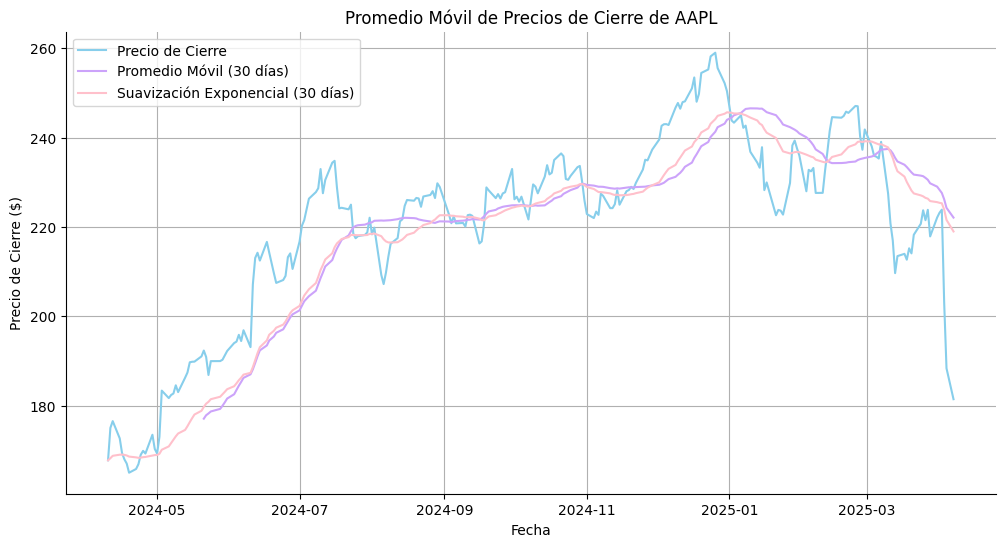

In [3]:
# Promedio Móvil Simple
ventana_sma = 30
df['SMA'] = df['AAPL_Close'].rolling(window=ventana_sma).mean()

# Promedio Móvil Exponencial
ventana_ses = 30
df['SES'] = df['AAPL_Close'].ewm(span=ventana_ses, adjust=False).mean()

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df['AAPL_Close'], label='Precio de Cierre', color='skyblue')
plt.plot(df['SMA'], label=f'Promedio Móvil ({ventana_sma} días)', color='#CCA3FA') #los colores con html se le agrega un gato
plt.plot(df['SES'], label=f'Suavización Exponencial ({ventana_ses} días)', color='pink')
plt.title('Promedio Móvil de Precios de Cierre de AAPL')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.grid()
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

El promedio móvil calcula el precio promedio de los últimos 30 días, lo que ayuda a identificar la dirección general del precio, con cruces por encima indicando posibles tendencias alcistas y por debajo sugiriendo tendencias bajistas. La suavización exponencial, similar en su propósito, otorga una mayor ponderación a los precios más recientes, haciéndola más sensible a los cambios de precio inmediatos en comparación con el promedio móvil simple. En conjunto, estas líneas permiten a los analistas observar la volatilidad del precio diario, discernir la tendencia subyacente a corto plazo y potencialmente identificar puntos de cambio en esta tendencia a través de los cruces entre el precio de cierre y los promedios móviles. Es fundamental entender que estos indicadores son herramientas de análisis y deben complementarse con otras formas de análisis para fundamentar decisiones de inversión.

# Prueba Dickey-Fuller Aumentada

In [4]:
#Prueba de estacionariedad: Prueba de Dickey-Fuller aumentada (ADF)

#Hipótesis nula (H₀): La serie tiene una raíz unitaria (no es estacionaria).
#Hipótesis alternativa (H₁): La serie es estacionaria.

from statsmodels.tsa.stattools import adfuller

nivel_de_significancia = 0.05

# Realizar la prueba de Dickey-Fuller en los la tendencia
adf_test = adfuller(df['AAPL_Close'].dropna()) # Realiza la prueba ADF


# Interpretación de la prueba ADF
print('Estadístico ADF:', adf_test[0])
print('p-value:', adf_test[1])

if adf_test[1] <= nivel_de_significancia:
    print("La tendencia es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La tendencia no es estacionaria (aceptamos la hipótesis nula).")
#Para deterctar estacionalidad

Estadístico ADF: -1.7739528573286973
p-value: 0.39346788381035025
La tendencia no es estacionaria (aceptamos la hipótesis nula).


# Regresión polinomial

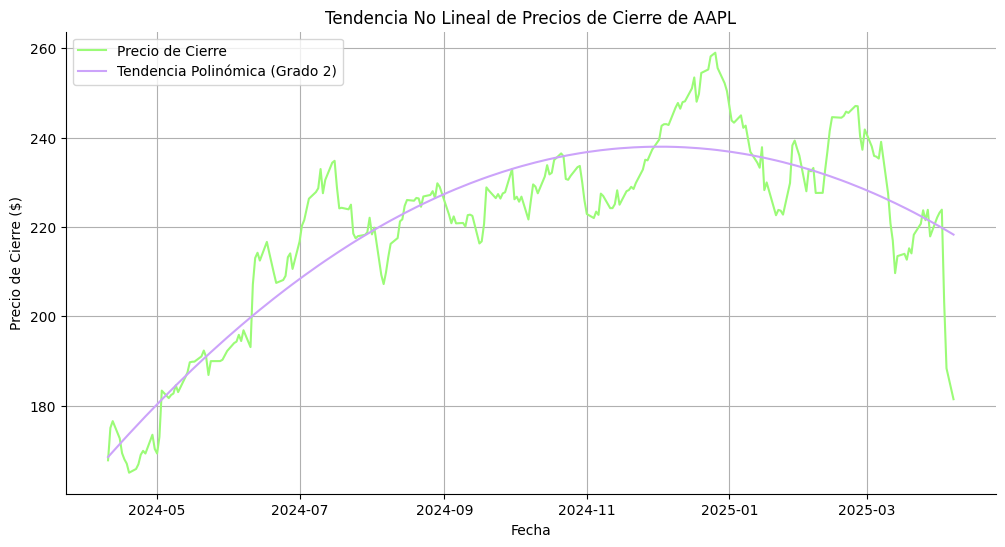

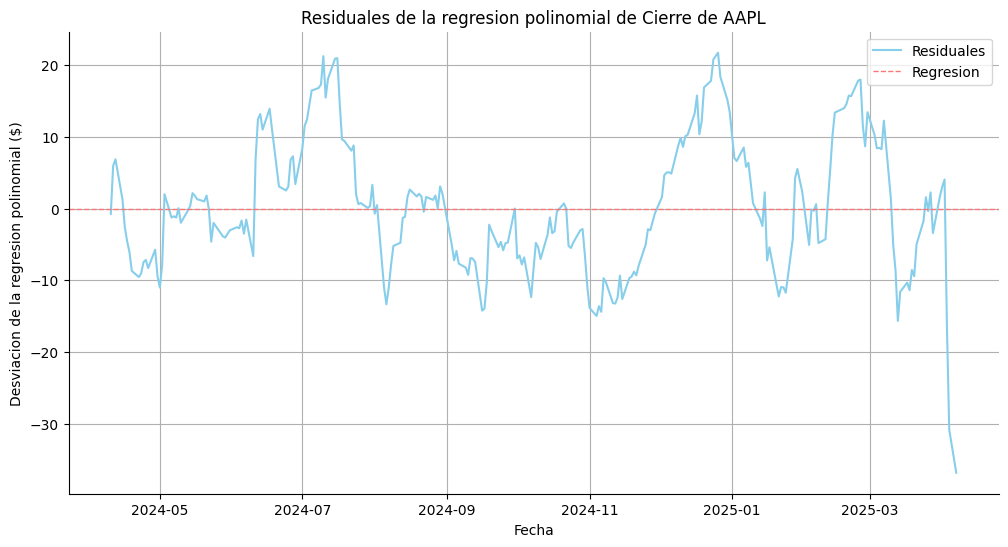

In [5]:
from numpy.polynomial.polynomial import Polynomial

# Paso 1: Convertir fechas a números
# Creamos una nueva columna llamada 'Date' la cual contiene las fechas en
# segundos desde el 1 de de enero de 1970 (tiempo UNIX)
df['Date'] = pd.to_datetime(df.index).map(pd.Timestamp.timestamp)

# Paso 2: Definir las variables independientes (X) y la variable dependiente (y)
X = df['Date']
y = df['AAPL_Close']

# Paso 3: Ajustar un modelo polinómico
grado = 2
modelo = Polynomial.fit(X, y, deg = grado)
df['Poly_Trend'] = modelo(X)
df['Poly_Resid'] = y - df['Poly_Trend']

# Graficar polinomial
# abre una nueva ventana gráfica
plt.figure(
    figsize=(12, 6) # tamaño (horizontal, vertical)
    )

# qué se va a graficar:
plt.plot(
    y,
    label='Precio de Cierre', # etiqueta que aparecerá en la leyenda
    color='#9BFB77'
    )

plt.plot(df['Poly_Trend'], label=f'Tendencia Polinómica (Grado {grado})', color='#CCA3FA')
plt.title('Tendencia No Lineal de Precios de Cierre de AAPL') # Título
plt.xlabel('Fecha')                                           # nombre del eje x
plt.ylabel('Precio de Cierre ($)')                            # nombre del eje y
plt.legend()                                                  # agrega la leyenda
plt.grid()                                                    # agrega una cuadrícula
plt.gca().spines['top'].set_visible(False)                    # elimina los bordes superiores
plt.gca().spines['right'].set_visible(False)                  # elimina los bordes derechos
plt.show()                                                    # muestra el gráfico (innecesario en colab)




# Graficar los residuales del polinomio
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['Poly_Resid'], label='Residuales', color='skyblue')
plt.axhline(0, color='#FB7777', label='Regresion',linestyle='--', linewidth=1)  # Línea horizontal en el valor cero
plt.title('Residuales de la regresion polinomial de Cierre de AAPL')
plt.xlabel('Fecha')
plt.ylabel('Desviacion de la regresion polinomial ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

#Representar la curva de forma más suave

La primera gráfica se centró en modelar la tendencia del precio de cierre a largo plazo utilizando una regresión polinómica de grado 2. Esta curva reveló una tendencia no lineal, con una fase alcista inicial que culminó en un punto máximo alrededor de finales de 2024 o principios de 2025, seguida de una fase bajista. Esta representación suavizó las fluctuaciones diarias y ofreció una visión de la dirección general del precio a lo largo del periodo analizado.

La segunda gráfica, la de los residuales de esta regresión polinómica, nos proporcionó información crucial sobre la calidad del ajuste de este modelo de tendencia. Los residuales, que representan la diferencia entre el precio real y el predicho por la curva polinómica, mostraron fluctuaciones considerables alrededor de cero. Esto indica que, si bien la tendencia polinómica de grado 2 capturó la dirección general del movimiento del precio a largo plazo, no logró explicar todas las variaciones diarias y a mediano plazo. La magnitud de los residuales señaló momentos en los que la predicción de la tendencia se desvió significativamente del precio real. La ausencia de un patrón lineal claro en los residuales sugiere que el modelo no tiene un sesgo sistemático obvio, pero las fluctuaciones indican que otros factores, no capturados por la simple tendencia polinómica de segundo grado, influyeron en el precio de AAPL durante este periodo.

## Para Pros: Series de Fourier

Las series de Fourier descomponen cualquier cosa como una suma de senos y cosenos. Por esta razón, son una herramienta útil para extraer patrones oscilantes. Este es un tema muy complicado y alejado a todo lo que han manejado, por esta razón no les voy a pedir que lo usen. Aquí lo he simplificado tanto como he podido por si se animan.

In [6]:
# Aquí no le muevan a nada
# Básicamente, lo que se hace este bloque es crear la función
# Transformada_de_Fourier, puesto a que no existe para lo que la quiero usar.

def Transformada_de_Fourier(serie, terminos, un_grafico):
  '''La función acepta los argumentos "serie", la cual debe de ser un array
  en numpy y en pandas de la forma df["my_variable"].values. Por otra parte,
  el parámetro "terminos" es un número natural que indica la cantidad de
  términos que desarrolla la serie. Entre mayor sea el número de términos,
  la serie será más precisa, pero más difícil de interpretar.

  La función tiene como salida una lista con los componentes sinosoidales de serie.
  El último elemento de la lista, es la suma de todos los componentes'''

  import numpy as np
  import matplotlib.pyplot as plt
  import pandas as pd
  from scipy.fftpack import fft, ifft

  # Supongamos que tienes una serie en df['AAPL_Close']
  # Reemplaza esta línea con tu DataFrame y serie específicos
  n = len(serie)

  # Calcular la transformada de Fourier
  transformada_fourier = fft(serie)

  # Obtener las frecuencias
  frecuencias = np.fft.fftfreq(n)

  # Crear un DataFrame para almacenar la frecuencia y su magnitud
  componentes = pd.DataFrame({
      'frecuencia': frecuencias,
      'magnitud': np.abs(transformada_fourier),
      'longitud_de_onda': 1 / frecuencias
  })

  # Ordenar el dataframe de mayor a menor en términos de magnitud

  componentes = componentes.sort_values(by='magnitud', ascending=False)

  # Seleccionar las frecuencias con mayor magnitud (excluyendo la frecuencia cero)
  top_frecuencias = componentes.loc[componentes['frecuencia'] > 0].nlargest(terminos, 'magnitud')
  top_frecuencias.reset_index(drop=True, inplace=True)
  print("Frecuencias principales:\n", top_frecuencias)

  # Crear el índice de tiempo para la serie
  t = np.arange(n)

  # Graficar cada componente de frecuencia junto con la serie original
  plt.figure(figsize=(12, 4))

  componente_temporal_sumado = np.zeros_like(serie)
  componentes_temporales = []

  n=0
  for i, row in top_frecuencias.iterrows():
      n+=1
      # Copiar la transformada de Fourier y mantener solo la frecuencia actual
      fourier_component = np.zeros_like(transformada_fourier)
      idx = np.where(frecuencias == row['frecuencia'])[0][0]  # índice de la frecuencia en la FFT
      fourier_component[idx] = transformada_fourier[idx]  # mantener solo la frecuencia positiva
      fourier_component[-idx] = transformada_fourier[-idx]  # mantener la frecuencia negativa correspondiente
      if n == (terminos+1):
        break

      # Reconstruir la señal en el tiempo
      componente_temporal = ifft(fourier_component).real
      componentes_temporales.append(componente_temporal)
      componente_temporal_sumado += componente_temporal

      # Graficar la componente
      plt.plot(
          componente_temporal,
          label=f'Longitud de onda {1 / row["frecuencia"]:.0f}',
          alpha=1,
          linewidth = 0.5,
          )
      plt.title('Componentes de Fourier de la Serie')
      plt.xlabel('Tiempo')
      plt.ylabel('Valor')
      plt.legend()
      plt.grid()

  componentes_temporales.append(componente_temporal_sumado)
  plt.plot(serie, label='Serie Original', color='black', alpha=0.5)
  if not un_grafico:
    plt.figure(figsize=(12, 4))
    plt.plot(serie, label='Serie Original', color='black', alpha=0.5)
  plt.plot(componente_temporal_sumado, label='Componente temporal sumada', color='#779BFB')
  plt.legend()
  plt.title('Suma de los Componentes de Fourier de la Serie')
  plt.xlabel('Tiempo')
  plt.ylabel('Valor')
  plt.grid()
  plt.show()

  return componentes_temporales

  #Descompone los residuales, y la segunda tabla las suma y las acomoda a su favor

Frecuencias principales:
    frecuencia    magnitud  longitud_de_onda
0    0.008032  889.201137        124.500000
1    0.024096  596.401363         41.500000
2    0.020080  524.679708         49.800000
3    0.016064  372.993586         62.250000
4    0.028112  321.138070         35.571429


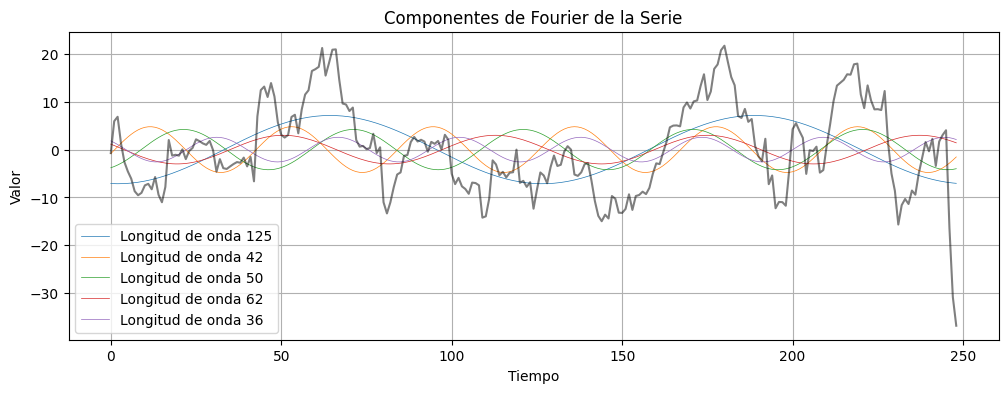

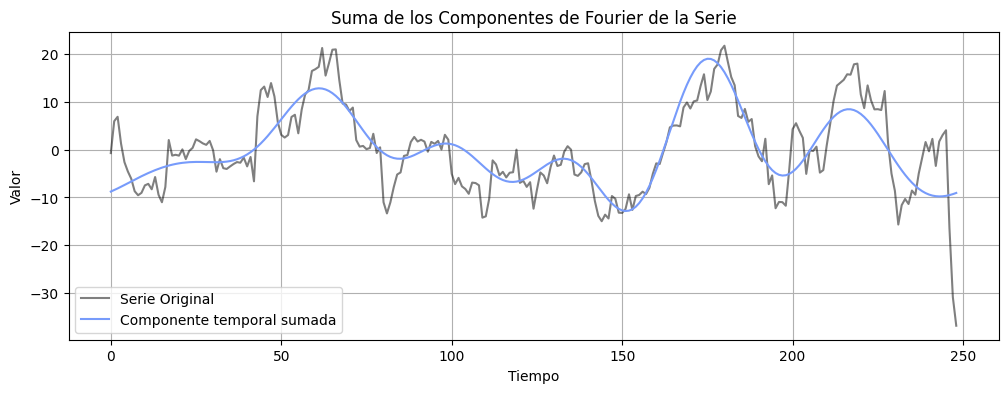

In [7]:
serie = df['Poly_Resid'].values
terminos = 5
un_grafico = False

cts = Transformada_de_Fourier(serie, terminos, un_grafico)

# cts: componente temporal sumado


En estos gráficos, la longitud de onda equivale a la unidad de tiempo (en este caso, días) que tarda la onda en volver al mismo sitio. Algo que en nuestro contexto podríamos interpretar como estasionalidad. Vemos que la oscilación más grande se presenta cada 378 días. Dado que esto es más de un año, esto sería más bien un ciclo. Sin embargo, se puede apreciar algo muy interesante, la longitud de onda siguiente es de 126 en unidades de tiempo (días) que es justo la mitad de la cantidad de días de negociación en un año!!! 😯

# Gráfico de autocorrelación

El gráfico de autocorrelación tiene como eje vertical los valores de la r de Pearson objenidos desplazando la serie hacia atrás en el tiempo. La medida de estos desplazamientos se muestra en el eje horizontal "lags". Se puede ver que de fondo hay una especie de sombra, esa sombra muestra el intervalo de confianza con el nivel de significancia que establezcan. Si la r de Pearson para un lag específico está fuera fuera de esa sombra, hay un nivel de confianza para afirmar que $r\neq0$ y por lo tanto hay correlación.
<br>
Este gráfico se usa para muchas cosas. Nosotros lo intentamos usar para obtener la estacionalidad, pero también se usa para obtener algunos parámetros del modelo ARIMA.

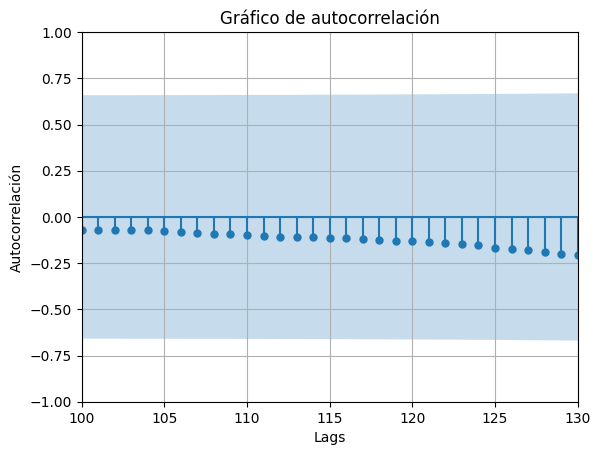

In [8]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

nivel_de_significancia = 0.05

plot_acf(
    df['AAPL_Close'],
    lags=130,
    alpha=nivel_de_significancia
    )

plt.xlim([100, 130])
plt.ylim([-1, 1])
plt.title('Gráfico de autocorrelación')
plt.xlabel('Lags')
plt.ylabel('Autocorrelación')
plt.grid()
plt.show()

Finalmente, el gráfico de autocorrelación de los residuales, para los lags examinados, no evidencia una autocorrelación estadísticamente significativa, lo que sugiere que los errores del modelo son relativamente aleatorios para estos rezagos. En conjunto, el precio de AAPL presenta una tendencia no lineal a largo plazo con fluctuaciones a corto plazo, y aunque un modelo polinómico de segundo grado captura la dirección general, no explica completamente la dinámica del precio, cuyos errores parecen ser independientes para los rezagos más largos analizados.

# Gráfico de autocorrelación parcial (PACF)

Su propósito principal es ayudar a identificar el orden de dependencia en una serie temporal (útil para ARIMA), es decir, cuántos valores anteriores están correlacionados con el valor actual, después de eliminar el efecto de las observaciones intermedias.

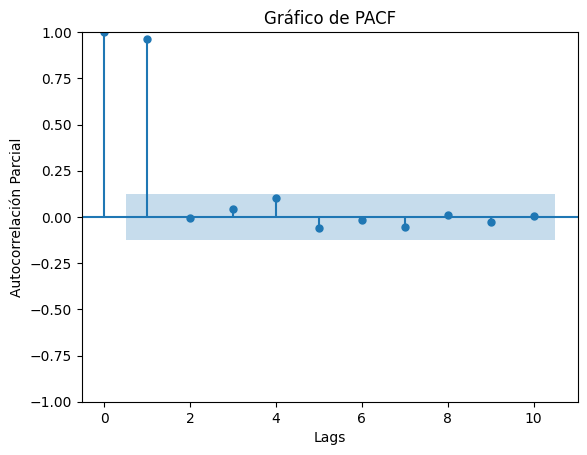

In [9]:
# Generar el gráfico PACF
from statsmodels.graphics.tsaplots import plot_pacf

nivel_de_significancia = 0.05
plot_pacf(df['AAPL_Close'], lags=10, alpha=nivel_de_significancia)
plt.title('Gráfico de PACF')
plt.xlabel('Lags')
plt.ylabel('Autocorrelación Parcial')
plt.show()


# Descomposición de la serie

`sm.tsa.seasonal_descompose` descompone la serie de tiempo en los componentes Trend, Seasonal y Resid, que son Tendencia, Estacionalidad y Residuos, respectivamente. De tal manera que la serie de tiempo es igual la suma de estos tres elementos.

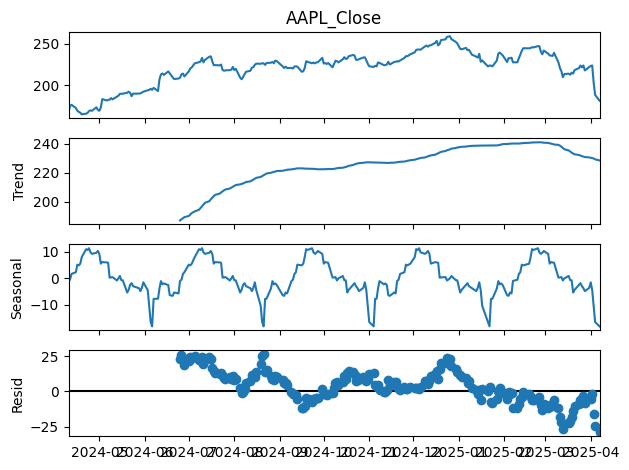

In [10]:
# Descomponer la serie temporal
import statsmodels.api as sm

descomposicion = sm.tsa.seasonal_decompose(
    df['AAPL_Close'],
    model='additive',
    period=52,
    extrapolate_trend=0,
    two_sided=False,
    )  # 252 días de negociación al año
fig = descomposicion.plot()
plt.show()

el ruido siempre se va a llevar un poco de estacionalidad
el ruido no debe tener tendencia, debe ser estacionario\
¡Claro! Esta gráfica muestra la descomposición de la serie temporal del precio de cierre de AAPL en sus componentes: tendencia, estacionalidad y residuo.

El primer panel superior muestra la serie temporal original del precio de cierre de AAPL a lo largo del tiempo. El segundo panel ilustra la tendencia subyacente del precio, representando el movimiento a largo plazo después de eliminar las fluctuaciones a corto plazo y la estacionalidad. Se observa una tendencia alcista general hasta mediados de 2025, seguida de un descenso. El tercer panel exhibe la componente estacional, que captura patrones repetitivos dentro de un periodo fijo. En este caso, parece haber una estacionalidad con fluctuaciones regulares a lo largo del año. Finalmente, el cuarto panel muestra los residuales o el ruido, que son las fluctuaciones irregulares que no se explican por la tendencia ni la estacionalidad. Estos residuales deberían ser aleatorios si el modelo de descomposición captura adecuadamente los componentes de la serie temporal.

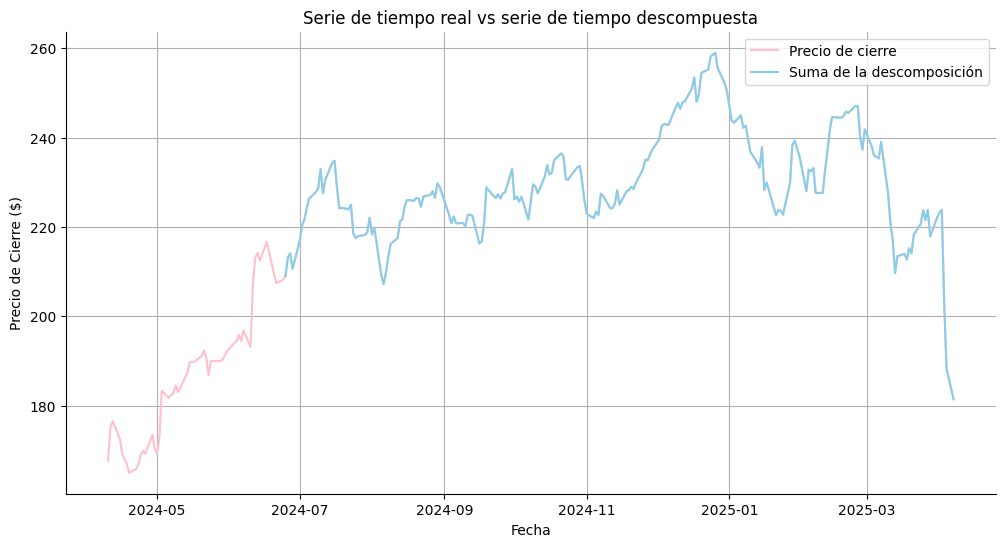

In [11]:
# Graficar descomposición
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['AAPL_Close'], label='Precio de cierre', color='pink')
plt.plot(descomposicion.trend + descomposicion.seasonal + descomposicion.resid, label=f'Suma de la descomposición', color='skyblue')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

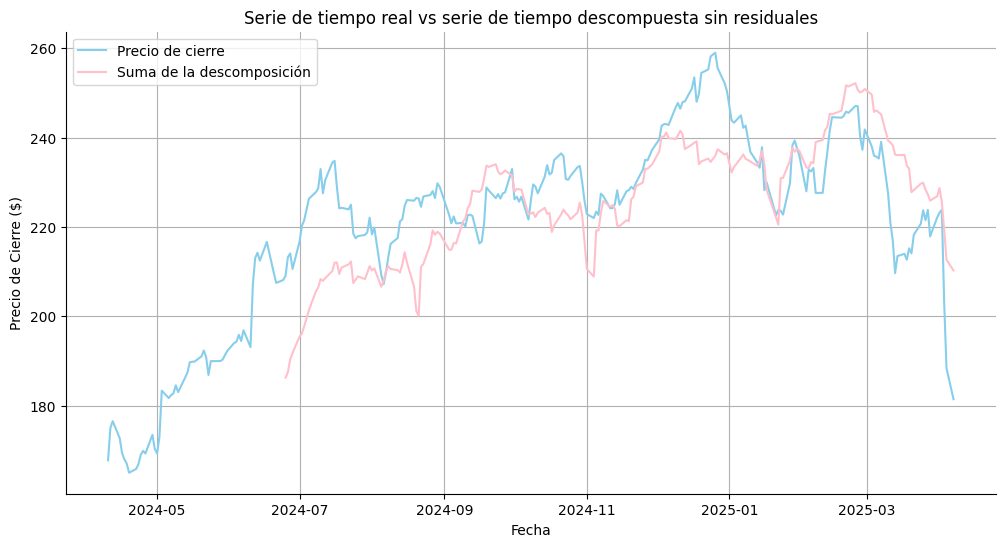

In [12]:
# Graficar descomposición
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['AAPL_Close'], label='Precio de cierre', color='skyblue')
plt.plot(descomposicion.trend + descomposicion.seasonal, label=f'Suma de la descomposición', color='pink')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta sin residuales')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

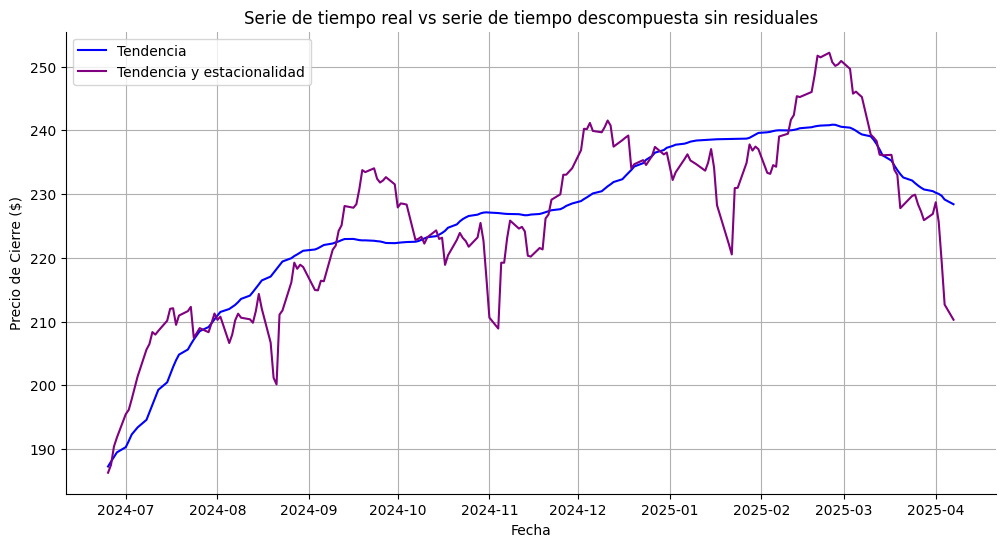

In [13]:
# Graficar descomposición
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(descomposicion.trend, label='Tendencia', color='blue')
plt.plot(descomposicion.trend + descomposicion.seasonal, label=f'Tendencia y estacionalidad', color='purple')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta sin residuales')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

**Importante**: Es posible que hayan campturado bien la estacionalidad y que la prueba ADF de los residuales les indique que hay estacionariedad. Sin embargo, en el gráfico anterior vemos que no hay mucha diferencia entre la tendencia y la tendencia con estacionalidad. Por lo tanto, la estacionalidad, aunque existe, no es significativa. Esto se ilustra en el siguiente gráfico.

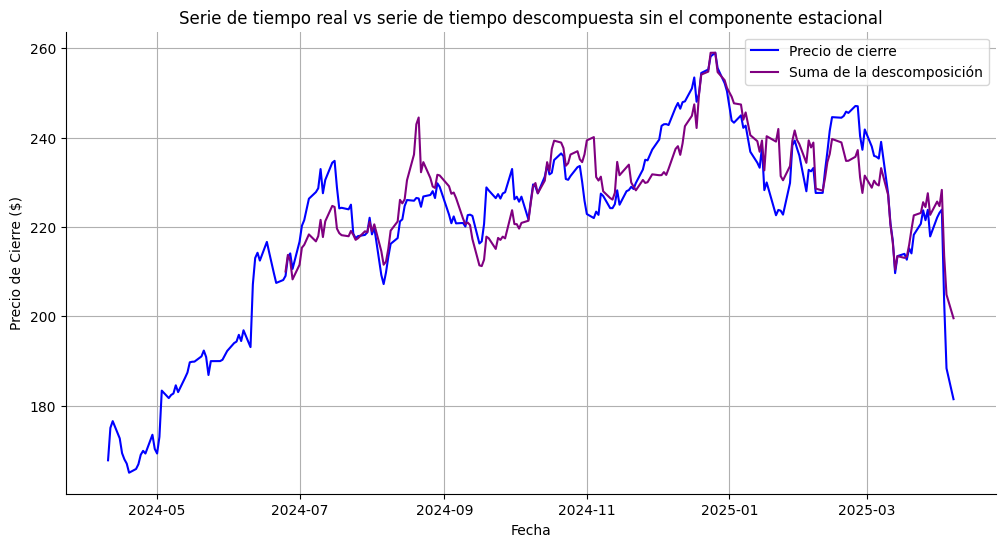

In [14]:
# Graficar descomposición
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['AAPL_Close'], label='Precio de cierre', color='blue')
plt.plot(descomposicion.trend + descomposicion.resid, label=f'Suma de la descomposición', color='purple')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta sin el componente estacional')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [15]:
from scipy.stats import ttest_rel

# Prueba t pareada para el efecto significativo de la estacionalidad

#Hipótesis nula (H₀): Ambas series son iguales.
#Hipótesis alternativa (H₁): Ambas series son diferentes


nivel_de_significancia = 0.05
tendencia = descomposicion.trend
tendencia_estacionalidad = descomposicion.seasonal + descomposicion.trend

# Eliminar valores NaN de ambas series
tendencia.dropna(inplace=True)
tendencia_estacionalidad.dropna(inplace=True)

# Realizar la prueba t pareada
t_stat, p_valor = ttest_rel(tendencia, tendencia_estacionalidad)

print("Estadístico t:", t_stat)
print("Valor p:", p_valor)
print("\n")

# Interpretación de los resultados
if p_valor < nivel_de_significancia:
    print("El valor p es menor que 0.05, por lo tanto, rechazamos la hipótesis nula.")
    print("Conclusión: La estacionalidad tiene un efecto significativo en la serie de tiempo.")
else:
    print("El valor p es mayor o igual que 0.05, por lo tanto, no podemos rechazar la hipótesis nula.")
    print("Conclusión: La estacionalidad no tiene un efecto significativo en la serie de tiempo.")


Estadístico t: -0.5430399579176226
Valor p: 0.5877193063481974


El valor p es mayor o igual que 0.05, por lo tanto, no podemos rechazar la hipótesis nula.
Conclusión: La estacionalidad no tiene un efecto significativo en la serie de tiempo.


In [16]:
from scipy.stats import wilcoxon

# Prueba Wilcoxon pareada para el efecto significativo de la estacionalidad

#Hipótesis nula (H₀): Ambas series son iguales.
#Hipótesis alternativa (H₁): Ambas series son diferentes

tendencia = descomposicion.trend
tendencia_estacionalidad = descomposicion.seasonal + descomposicion.trend

# Eliminar valores NaN de ambas series
tendencia.dropna(inplace=True)
tendencia_estacionalidad.dropna(inplace=True)

# Realizar la prueba de Wilcoxon
w_stat, p_valor = wilcoxon(tendencia, tendencia_estacionalidad)

print("Estadístico de Wilcoxon:", w_stat)
print("Valor p:", p_valor)
print("\n")

# Interpretación de los resultados
if p_valor < 0.05:
    print("El valor p es menor que 0.05, por lo tanto, rechazamos la hipótesis nula.")
    print("Conclusión: La estacionalidad tiene un efecto significativo en la serie de tiempo.")
else:
    print("El valor p es mayor o igual que 0.05, por lo tanto, no podemos rechazar la hipótesis nula.")
    print("Conclusión: La estacionalidad no tiene un efecto significativo en la serie de tiempo.")


Estadístico de Wilcoxon: 9355.0
Valor p: 0.6206823441713512


El valor p es mayor o igual que 0.05, por lo tanto, no podemos rechazar la hipótesis nula.
Conclusión: La estacionalidad no tiene un efecto significativo en la serie de tiempo.


Considerando todas las gráficas analizadas, el precio de cierre de AAPL entre abril de 2024 y abril de 2025 exhibió una tendencia no lineal a largo plazo, inicialmente alcista con un pico a finales de 2024 o principios de 2025, seguida de un descenso. A corto plazo, el precio mostró volatilidad, con tendencias que pudieron identificarse mediante promedios móviles y suavización exponencial. Un análisis de descomposición de la serie temporal reveló además una tendencia subyacente similar a la observada con la regresión polinómica, una componente estacional con fluctuaciones regulares a lo largo del año, y residuales que representan el ruido o las fluctuaciones no explicadas por la tendencia y la estacionalidad. El análisis de los residuales de la regresión polinómica indicó que, si bien el modelo capturó la dirección general, no explicó completamente la variabilidad del precio, aunque para rezagos más largos (100-130), no se encontró una autocorrelación significativa en los errores. En general, el precio de AAPL durante este periodo estuvo influenciado por una combinación de una tendencia a largo plazo, patrones estacionales y fluctuaciones irregulares, con la tendencia a largo plazo mostrando un comportamiento no lineal.